In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import json
import os

DB_EPS = 1e-6
EPS = 1e-9

In [2]:
def get_files(path):
  ret = []
  for root, _, files in os.walk(path, topdown=False):
    for file in files:
      ret.append({'path': os.path.join(root,file), 'data' : None})
  return ret

In [3]:
hypertone_dir = '/content/drive/MyDrive/hypertone/'
preprocessing_data_file = hypertone_dir + 'preprocessing/data.json'
model_dir = hypertone_dir + 'model/'
model_file = hypertone_dir + 'model/model.h5'
directory = '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie'
tones = {tone : {'dir' : directory + '/utrenia-glas' + str(tone) + '-macarie/Inregistrari', 'files' : None} for tone in list(range(1, 8 + 1))}

In [4]:
tones

{1: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari',
  'files': None},
 2: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari',
  'files': None},
 3: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari',
  'files': None},
 4: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari',
  'files': None},
 5: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari',
  'files': None},
 6: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari',
  'files': None},
 7: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari',
  'files': None},
 8: {'

In [5]:
for tone in tones.keys():
  tones[tone]['files'] = get_files(tones[tone]['dir'])
tones[1]['files']

[{'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 9 Ceea ce eşti mai cinstită.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.2 Troparele.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 15 Preabinecuvântată eşti.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.6 Antifoanele.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.7 Prochimenul.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.12 Stihira 2 Laude.m4a'},
 {'data': 

In [121]:
kTones = 8
kBinsPerOctave = 24
kJump = int(4/3 * kBinsPerOctave)

fmin = librosa.midi_to_hz(36) # C2
fmax = librosa.midi_to_hz(84) # C6

In [122]:
def debug_frequencies(freqs):
  print("size=" + str(len(freqs)))
  for index, elem in enumerate(freqs):
    c = '\n' if index % 8 == 0 else ' || '
    print(str(index) + " -> " + str(int(elem)),end=c)
  print('')
  pass


def debug(curr, b, e):
  for x in curr[b:e]:
    for elem in x:
      print(elem, end=',')
    print('')
  pass

def plot_lms(lms_, sr_):
  plt.figure(figsize=(30, 10))
  librosa.display.specshow(lms_, 
                          x_axis="time",
                          y_axis="mel", 
                          sr=sr_)
  plt.colorbar(format="%+2.f")
  plt.show()
  pass

def lower_bound(arr, needle):
# Lower-bound to find frequencies
  n = len(arr)
  lower, half = 0, n // 2
  while half:
    middle = lower + half;
    lower = middle if arr[middle] <= needle else lower
    n -= half
    half = n // 2
  return lower

In [123]:
# TODO: adaptively change this!
kOffset = 250 # 5 sec

# TODO: use also CQT_CHROMA!!!
def analyze_audio(filename, verbose=False):
  scale, sr = librosa.load(filename)
  fmin = librosa.midi_to_hz(36) # C2
  fmax = librosa.midi_to_hz(84) # C6 (not used)

  # TODO: put 24 bins per octave
  X = librosa.cqt(scale[kOffset:], sr=sr, fmin=fmin, bins_per_octave=kBinsPerOctave)  
  kBins = X.shape[0]
  print("initial=" + str(X.shape))

  pos_fmax = lower_bound(librosa.cqt_frequencies(n_bins=kBins, fmin=fmin), fmax)

  orig_logX = librosa.amplitude_to_db(abs(X))
  
  # Transpose
  logX = np.transpose(orig_logX).copy()

  # Zero-out minus db
  logX[logX < 0] = 0

  # Zero-out > fmax
  logX[:,(1 + pos_fmax):] = 0

  # Clear empty columns
  logX = logX[~np.all(logX < DB_EPS, axis=1)]

  # Scale
  # Do we need to rescale?
  #scaler = MinMaxScaler()
  #logX = scaler.fit_transform(logX)
  
  print("transofrmed=" + str(logX.shape))
  
  if verbose:
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(logX.T, sr=sr, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

  melody = []
  for index in range(len(logX)):
    tmp = np.zeros(kBinsPerOctave)
    for bin in range(kBins):
      tmp[bin % kBinsPerOctave] += logX[index][bin]
    max_pos = np.argmax(tmp)
    assert 0 <= max_pos and max_pos < kBinsPerOctave
    melody.append(max_pos)
  return np.asarray(melody)

In [124]:
def compress(a):
  return a[np.logical_or(np.insert(np.diff(a).astype(bool), 0, True), np.asarray(a, dtype=bool))]

# TODO: for half of second, get mean of the bin, since there might be noise!
def encode_audio(filename):
  melody = analyze_audio(filename)
  print(melody.shape)
  compressed = compress(np.diff(melody))
  print(compressed.shape)
  return compressed

In [125]:
filename=tones[1]['files'][0]['path']
ipd.Audio(filename)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1760)
transofrmed=(909, 84)
(909,)
(417,)


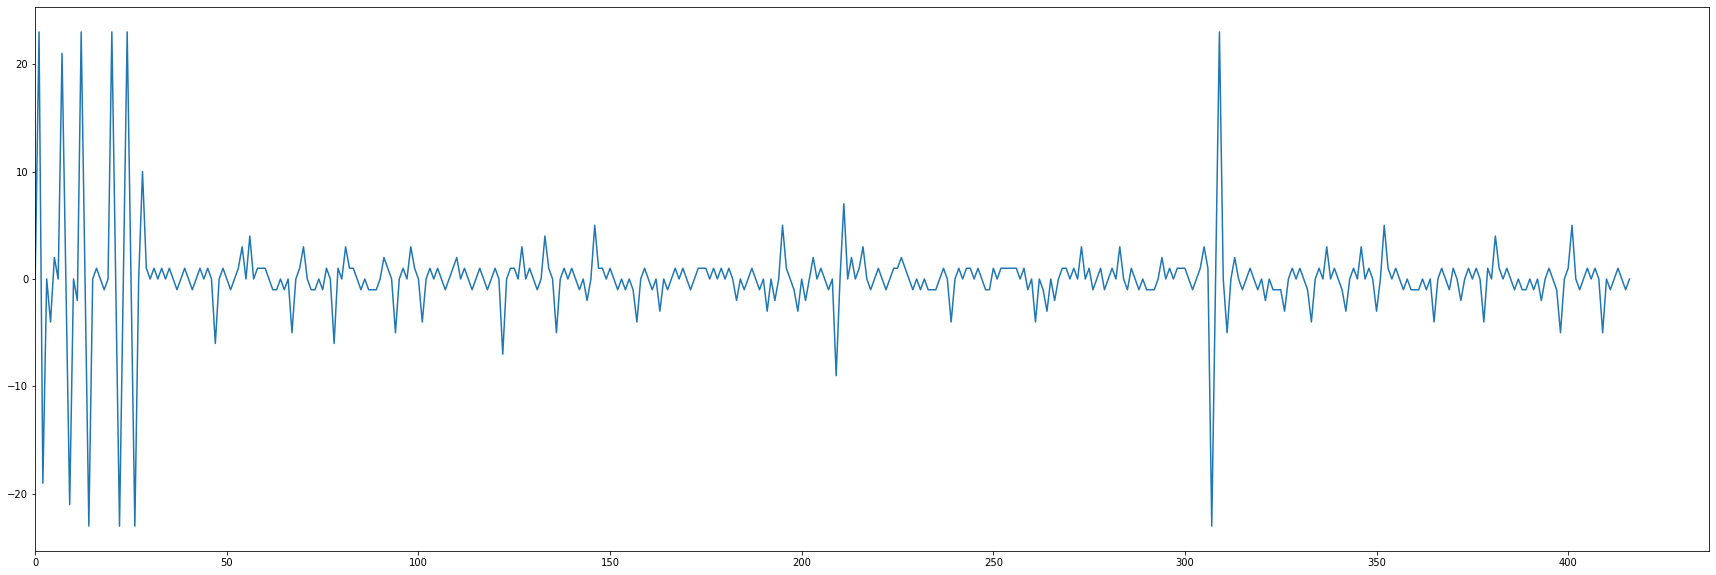

In [126]:
encoded_audio = encode_audio(filename)
plt.figure(figsize=(30, 10))
plt.plot(encoded_audio)
plt.xlim(xmin=0)
plt.show()

In [127]:
def preprocess():
  for tone in tones:
    if tone != 8 and tone != 1:
      continue
    print('Tone: ' + str(tone))
    count = 2
    for index, file in enumerate(tones[tone]['files']):
      #if index == count:
      #  break
      print('Audio: ' + file['path'])
      tones[tone]['files'][index]['data'] = encode_audio(file['path'])
  pass

In [128]:
preprocess()

Tone: 1
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 9 Ceea ce eşti mai cinstită.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1760)
transofrmed=(909, 84)
(909,)
(417,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.2 Troparele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5844)
transofrmed=(4604, 84)
(4604,)
(2043,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 15 Preabinecuvântată eşti.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2765)
transofrmed=(2015, 84)
(2015,)
(867,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.6 Antifoanele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 9308)
transofrmed=(7767, 84)
(7767,)
(3717,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.7 Prochimenul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2410)
transofrmed=(2032, 84)
(2032,)
(982,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.12 Stihira 2 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2468)
transofrmed=(1963, 84)
(1963,)
(999,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.14 Stihira 4 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5117)
transofrmed=(4165, 84)
(4165,)
(1942,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.1 Dumnezeu este D.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1087)
transofrmed=(726, 84)
(726,)
(334,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.4 Al doilea rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 7204)
transofrmed=(5909, 84)
(5909,)
(2745,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.11 Stihira 1 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2102)
transofrmed=(1680, 84)
(1680,)
(835,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.10 Toată suflarea.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4955)
transofrmed=(4147, 84)
(4147,)
(2194,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.3 Primul rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 7406)
transofrmed=(6227, 84)
(6227,)
(3265,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.13 Stihira 3 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2956)
transofrmed=(2478, 84)
(2478,)
(1211,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.8 Toată suflare ante Ev.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1687)
transofrmed=(1147, 84)
(1147,)
(493,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.5 Ipacoiul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1414)
transofrmed=(1066, 84)
(1066,)
(452,)
Tone: 8
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.3 Primul rând de sedelne.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 9505)
transofrmed=(7408, 84)
(7408,)
(3294,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.7 Prochimenul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1485)
transofrmed=(1131, 84)
(1131,)
(471,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.10 Toată suflarea.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5149)
transofrmed=(4219, 84)
(4219,)
(1843,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.2 Troparele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5095)
transofrmed=(3718, 84)
(3718,)
(1495,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.8 Toată suflarea ante Ev.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1617)
transofrmed=(997, 84)
(997,)
(393,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.11 Stihira 1 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2521)
transofrmed=(1727, 84)
(1727,)
(750,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.4 Al doilea rând de sedelne.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 7397)
transofrmed=(5874, 84)
(5874,)
(2669,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.6 Antifoanele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 12289)
transofrmed=(8901, 84)
(8901,)
(3738,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.5 Ipacoiul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2174)
transofrmed=(1593, 84)
(1593,)
(740,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.13 Stihira 3 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2365)
transofrmed=(1801, 84)
(1801,)
(793,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.9 Ceea ce eşti mai cinstită.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1764)
transofrmed=(1103, 84)
(1103,)
(497,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.14 Stihira 4 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2135)
transofrmed=(1473, 84)
(1473,)
(623,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8. 1 Dumnezeu este D.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1215)
transofrmed=(973, 84)
(973,)
(466,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.12 Stihira 2 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2170)
transofrmed=(1512, 84)
(1512,)
(659,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8. 15 Preabinecuvântată eşti.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2865)
transofrmed=(1992, 84)
(1992,)
(911,)


In [129]:
def prepare_data():
  print('Save tones..')
  acc = []
  for tone in tones:
    print('Tone: ' + str(tone))
    for index, file in enumerate(tones[tone]['files']):
      if tones[tone]['files'][index]['data'] is not None:
        acc.append({'x': tones[tone]['files'][index]['data'].tolist(), 'y': tone - 1})
  return acc

with open(preprocessing_data_file, 'w') as f:
  data = prepare_data()
  json.dump(data, f, indent=2)

Save tones..
Tone: 1
Tone: 2
Tone: 3
Tone: 4
Tone: 5
Tone: 6
Tone: 7
Tone: 8


In [159]:
import tensorflow.keras as keras

# TODO: check the best one!
kSequenceLength = 128
kOutputUnits = 2 * kBinsPerOctave - 1
kNumUnits = [128, 64]
kLoss = "categorical_crossentropy"
kLearningRate = 0.001
kEpochs = 5
kBatchSize = 64

In [131]:
def load(path):
  with open(path, 'r') as f:
    return json.load(f)

In [142]:
def generate_training_sequences(seq_len):
  """Create input and output data samples for training. Each sample is a sequence.

  :param sequence_length (int): Length of each sequence. With a quantisation at 16th notes, 64 notes equates to 4 bars

  :return inputs (ndarray): Training inputs
  :return targets (ndarray): Training targets
  """

  # load songs and map them to int
  songs = load(preprocessing_data_file)

  inputs, targets = [], []
  for elem in songs:
    x = np.asarray(elem['x'])
    y = elem['y']
    #x[np.insert(np.diff(x).astype(np.bool), 0, True)]
    if len(x) < seq_len:
      x.resize(seq_len)
    num_sequences = len(x) - seq_len + 1
    for index in range(num_sequences):
      inputs.append(x[index : index + seq_len])
      targets.append(y)

  # one-hot encode the sequences  
  # inputs size: (# of sequences, sequence length, vocabulary size)
  inputs = keras.utils.to_categorical(inputs, num_classes=kOutputUnits)
  print(inputs.shape)
  #n = len(inputs)
  #inputs = np.reshape(inputs, (n, seq_len, 1))
  # normalize input
  #inputs = inputs / float(kOutputUnits)
  
  targets = keras.utils.to_categorical(targets, num_classes=kTones)
  print(targets.shape)
  print(f"There are {len(inputs)} sequences.")
  return inputs, targets

In [ ]:
print(generate_training_sequences(kSequenceLength))

In [160]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.callbacks import ModelCheckpoint

def build_model(shape, output_units, num_units, loss, learning_rate):
    """Builds and compiles model

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply

    :return model (tf model): The model
    """

    # create the model architecture
    #input = keras.layers.Input(shape=(None, output_units))
    #x = keras.layers.LSTM(num_units[0])(input)
    #x = keras.layers.LSTM(num_units[1])(x)
    #x = keras.layers.Dropout(0.2)(x)
    #output = keras.layers.Dense(kTones, activation="softmax")(x)
    #model = keras.Model(input, output)

    # compile model
    #model.compile(loss=loss,
    #              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    #              metrics=["accuracy"])

    print(shape)

    model = Sequential()
    model.add(LSTM(
        num_units[0],
        input_shape=(shape[1], shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(num_units[1]))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(kTones))
    model.add(Activation('softmax'))
    model.compile(loss=kLoss, optimizer='adam', metrics=["accuracy"])

    model.summary()
    return model

def train(output_units=kOutputUnits, num_units=kNumUnits, loss=kLoss, learning_rate=kLearningRate):
    """Train and save TF model.

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply
    """

    # generate the training sequences
    inputs, targets = generate_training_sequences(kSequenceLength)

    # build the network
    model = build_model(inputs.shape, output_units, num_units, loss, learning_rate)

    filepath = model_dir + "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    # train the model
    model.fit(inputs, targets, epochs=kEpochs, batch_size=kBatchSize, callbacks=callbacks_list)

    # save the model
    model.save(model_file)

In [161]:
train()

(38028, 128, 47)
(38028, 8)
There are 38028 sequences.
(38028, 128, 47)
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 128, 128)          90112     
_________________________________________________________________
lstm_27 (LSTM)               (None, 64)                49408     
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 520       
_________________________________________________________________
activation_15 (Activation)   (None, 8)                 0         
Total params: 140,296
Trainable params: 140,168

In [162]:
class HyperTone:
  """A class that wraps the LSTM model and offers utilities to generate melodies."""

  def __init__(self, path=model_file):
    """Constructor that initialises TensorFlow model"""
    self.model = keras.models.load_model(path)
  
  def extract_tones(self, x):
    # Pad, if necessary
    if len(x) < kSequenceLength:
      x.resize(kSequenceLength)

    y = []
    num_sequences = len(x) - kSequenceLength + 1
    print("num_sequences=" + str(num_sequences))
    for index in range(num_sequences):
      seed = x[index : index + kSequenceLength]

      #print(seed)

      # one-hot encode the seed
      onehot_seed = keras.utils.to_categorical(seed, num_classes=kOutputUnits)

      # (1, max_sequence_length, num of symbols in the vocabulary)
      onehot_seed = onehot_seed[np.newaxis, ...]


      #print(onehot_seed)

      # make a prediction
      probabilities = self.model.predict(onehot_seed)[0]
      #print(probabilities)
      index = self.sample(probabilities)
      y.append(1 + index)              
    return y

  def sample(self, probabilites, temperature=0.1):
    """Samples an index from a probability array reapplying softmax using temperature

    :param predictions (nd.array): Array containing probabilities for each of the possible outputs.
    :param temperature (float): Float in interval [0, 1]. Numbers closer to 0 make the model more deterministic.
        A number closer to 1 makes the generation more unpredictable.

    :return index (int): Selected output symbol
    """
    predictions = np.log(probabilites) / temperature
    probabilites = np.exp(predictions) / np.sum(np.exp(predictions))

    choices = range(len(probabilites)) # [0, 1, 2, 3]
    index = np.random.choice(choices, p=probabilites)

    return index

In [163]:
f10 = tones[1]['files'][0]['path']
f11 = tones[1]['files'][2]['path']
f80 = tones[8]['files'][1]['path']
f81 = tones[8]['files'][4]['path']

In [147]:
ipd.Audio(f11)

In [148]:
ipd.Audio(f81)

In [164]:
ht = HyperTone('/content/drive/MyDrive/hypertone/model/weights-improvement-05-0.0617-bigger.hdf5')
print(ht.extract_tones(encode_audio(f10)))
print(ht.extract_tones(encode_audio(f11)))
print(ht.extract_tones(encode_audio(f81)))
print(ht.extract_tones(encode_audio(f81)))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1760)
transofrmed=(909, 84)
(909,)
(417,)
num_sequences=290
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 8, 8, 8, 8, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2765)
transofrmed=(2015, 84)
(2015,)
(867,)
num_sequences=740
[8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1617)
transofrmed=(997, 84)
(997,)
(393,)
num_sequences=266
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1617)
transofrmed=(997, 84)
(997,)
(393,)
num_sequences=266
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
